In [74]:

import pandas as pd
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing
import networkx as nx
import osmnx as ox
import folium
from concave_hull import concave_hull_indexes
import numpy as np
from geopy.distance import geodesic
from PIL import Image
import io

#Génération de la map 
casino_location = (48.85286779713016, 2.3278106240257666)
casino_name="EXEMPLE"
size=300
size_limit=1000
if size >size_limit:
    taille=5000
    G = ox.graph_from_point(casino_location, dist=taille, network_type='drive')
    G = ox.add_edge_speeds(G)
else:
    taille=2500
    G = ox.graph_from_point(casino_location, dist=taille, network_type='walk')
    foot_speed=4
center_node = ox.distance.nearest_nodes(G, casino_location[1], casino_location[0])

if size > size_limit:
        for u, v, k, data in G.edges(data=True, keys=True):
            if data['speed_kph'] <=30:
                meters_per_second = (data['speed_kph'] * 0.7) * 1000 / 3600
            elif data['speed_kph'] <=50:
                meters_per_second = (data['speed_kph'] * 0.8) * 1000 / 3600
            else:
                meters_per_second = data['speed_kph'] * 1000 / 3600
            data['time'] = data['length'] / meters_per_second
else:
    for u, v, k, data in G.edges(data=True, keys=True):
        meters_per_second = foot_speed * 1000 / 3600
        data['time'] = data['length'] / meters_per_second

#Competiteurs 

competitors_data = pd.read_excel('geocoding.xlsx')

def calculate_distance(loc1, loc2):
    return geodesic(loc1, loc2).kilometers


filtered_competitors = []

for _,row in competitors_data.iterrows():
    competitor_location = (row['lat'], row['long'])
    distance = calculate_distance(casino_location, competitor_location)

    if distance <= taille/1000:
        filtered_competitors.append(row)
        
print(len(filtered_competitors))

list_names=[]
list_times=[]
list_distances=[]
list_noeuds=[]
list_lat=[]
list_long=[]
list_nearest_node_lat=[]
list_nearest_node_long=[]


for _, row in pd.DataFrame(filtered_competitors).iterrows():
        competitor_location = Point(row['long'], row['lat'])
        nearest_node = ox.distance.nearest_nodes(G, row['long'], row['lat'])
        node_coords = G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x']
        row['nearest_node_lat'] = node_coords[0]
        row['nearest_node_long'] = node_coords[1]
        if size > size_limit: 
            shortest_path = nx.shortest_path(G, source=center_node, target=nearest_node, weight='time', method='dijkstra')
        else:
            shortest_path = nx.shortest_path(G, source=center_node, target=nearest_node, weight='length', method='dijkstra')
        sum_times = 0
        sum_distances = 0
        for i in range(1,len(shortest_path)):
            edge_data = G.get_edge_data(shortest_path[i-1],shortest_path[i])[0]
            sum_times+=edge_data['time']
            sum_distances+=edge_data['length']
        list_times.append(sum_times/60)
        list_distances.append(sum_distances)
        list_names.append(row['concurent'])
        list_lat.append(row['lat'])
        list_long.append(row['long'])
        list_noeuds.append(row.name)
        list_nearest_node_lat.append(row['nearest_node_lat'])
        list_nearest_node_long.append(row['nearest_node_long'])
        
df_competitors = pd.DataFrame({
    'concurent': list_names,
    'nbr noeud': list_noeuds,
    'temps trajet': list_times,
    'distance': list_distances,
    'lat': list_lat,
    'long': list_long,
    'nearest_node_lat': list_nearest_node_lat,
    'nearest_node_long': list_nearest_node_long
})
df_competitors.to_excel(f"Casino {casino_name} competitors.xlsx",index=False)



#Partie Visuel : on fait un isochrone/map pour chaque travel_time
travel_times = [32,30,17,15]

for travel_time in travel_times:
    subgraph = nx.ego_graph(G, center_node, radius=travel_time*60, distance='time')
    isochrone = ox.graph_to_gdfs(subgraph, edges=False)
    points = [Point(lon, lat) for lon, lat in zip(isochrone['geometry'].x, isochrone['geometry'].y)]

    m = folium.Map(location=casino_location, zoom_start=13)

    point_array = np.array([[point.x, point.y] for point in points])
    idxes = concave_hull_indexes(
        point_array[:, :2],
        #length_threshold=1,
        concavity=1,
    )
    polygon_coords = point_array[idxes, ::-1].tolist()
    polygon = folium.Polygon(locations=polygon_coords, color='blue', fill=True, fill_color='blue', fill_opacity=0.4)
    polygon.add_to(m)

    for _, row in pd.DataFrame(df_competitors).iterrows():
        location = (row['nearest_node_lat'], row['nearest_node_long'])
        if row['temps trajet']<=travel_time:
            x=row['temps trajet']
            folium.Marker(location, 
                        popup=f'{x} min', 
                        icon=folium.Icon(color='red')).add_to(m)
        else:
            x=row['temps trajet']
            folium.Marker(location,popup=f'{x} min', 
                        icon=folium.Icon(color='blue')).add_to(m)
    # Adding markers for the center and points within the concave hull
    folium.Marker(location=(G.nodes[center_node]['y'], G.nodes[center_node]['x']), popup='Center Point', icon=folium.Icon(color='lightgreen')).add_to(m)
    img_data = m._to_png(5)

    img = Image.open(io.BytesIO(img_data))

    img.save(f'map {travel_time}.png')


266


There was an error managing firefox (error sending request for url (https://github.com/mozilla/geckodriver/releases/latest): error trying to connect: An existing connection was forcibly closed by the remote host. (os error 10054)); using driver found in the cache
There was an error managing firefox (error sending request for url (https://github.com/mozilla/geckodriver/releases/latest): error trying to connect: An existing connection was forcibly closed by the remote host. (os error 10054)); using driver found in the cache
There was an error managing firefox (error sending request for url (https://github.com/mozilla/geckodriver/releases/latest): error trying to connect: An existing connection was forcibly closed by the remote host. (os error 10054)); using driver found in the cache
There was an error managing firefox (error sending request for url (https://github.com/mozilla/geckodriver/releases/latest): error trying to connect: An existing connection was forcibly closed by the remote h

In [75]:
m

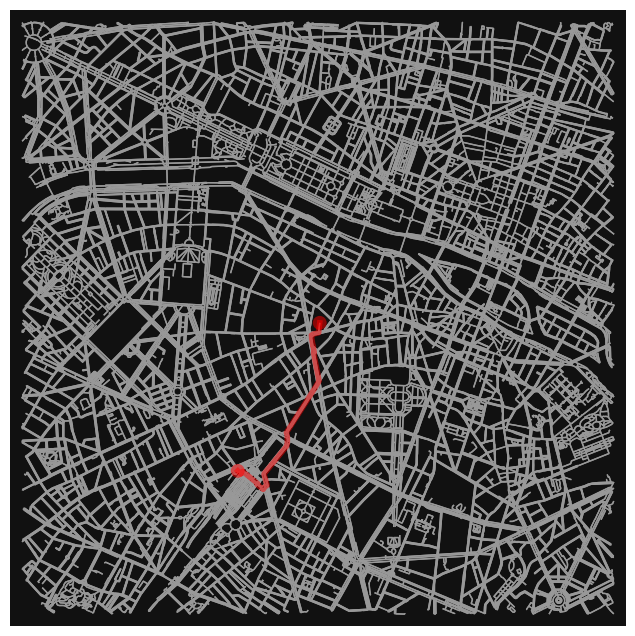

In [34]:

nearest_node = ox.distance.nearest_nodes(G, float("2.318683"), float("48.84129"))
center_node = ox.distance.nearest_nodes(G, casino_location[1], casino_location[0])
shortest_path = nx.shortest_path(G, source=center_node, target=nearest_node, weight='length', method='dijkstra')

# Plot the shortest path on the map
fig, ax = ox.plot_graph_route(G, shortest_path, route_color='red', route_linewidth=4, node_size=0)

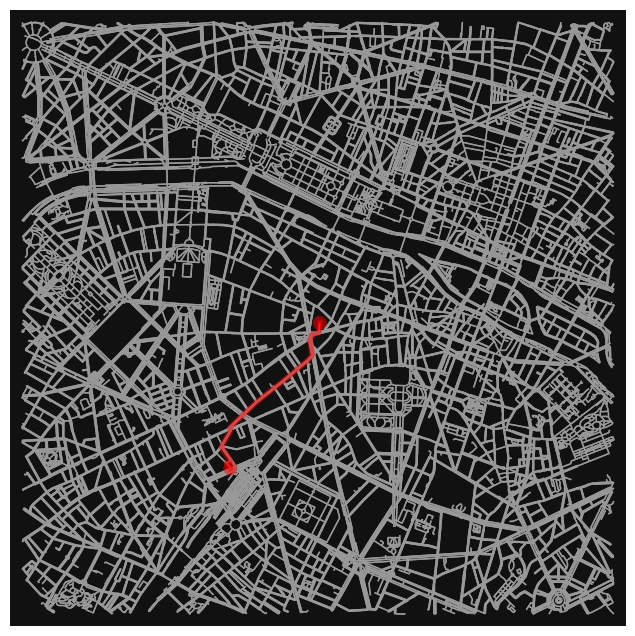

In [36]:
nearest_node = ox.distance.nearest_nodes(G, float("2.31739"), float("48.8415"))
center_node = ox.distance.nearest_nodes(G, casino_location[1], casino_location[0])
shortest_path = nx.shortest_path(G, source=center_node, target=nearest_node, weight='length', method='dijkstra')

# Plot the shortest path on the map
fig, ax = ox.plot_graph_route(G, shortest_path, route_color='red', route_linewidth=4, node_size=0)

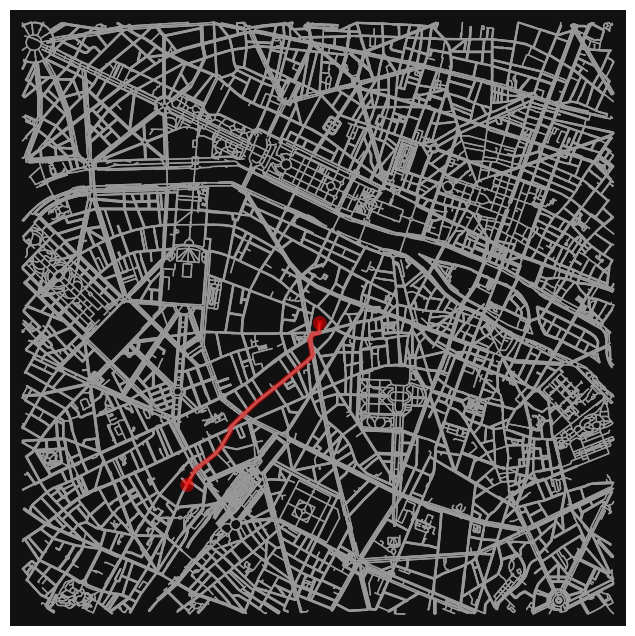

In [37]:
nearest_node = ox.distance.nearest_nodes(G, float("2.31272"), float("48.84015"))
center_node = ox.distance.nearest_nodes(G, casino_location[1], casino_location[0])
shortest_path = nx.shortest_path(G, source=center_node, target=nearest_node, weight='length', method='dijkstra')

# Plot the shortest path on the map
fig, ax = ox.plot_graph_route(G, shortest_path, route_color='red', route_linewidth=4, node_size=0)

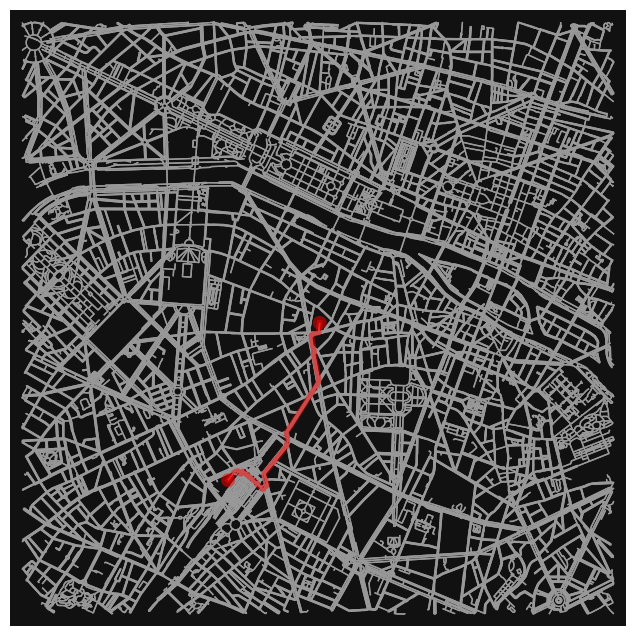

In [38]:
nearest_node = ox.distance.nearest_nodes(G, float("2.317404"), float("48.84091"))
center_node = ox.distance.nearest_nodes(G, casino_location[1], casino_location[0])
shortest_path = nx.shortest_path(G, source=center_node, target=nearest_node, weight='length', method='dijkstra')

# Plot the shortest path on the map
fig, ax = ox.plot_graph_route(G, shortest_path, route_color='red', route_linewidth=4, node_size=0)